# Format pyramidal cell spike data

author: steeve.laquitaine@epfl.ch

purpose: format spike snippets to assess whether missed sparse cell spike shape differ from universal templates more than detected sparse cells.

warning:
- better to set LOAD_WAVEFORM_EXTRACTOR = True to save 23 min at best (with LOAD_PREPROCESSED=True), 100 min in the worse case (re-run entire waveform extraction)

## Setup

setup environment `env_kilosort_silico`

In [8]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy


# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)
from src.nodes.prepro import preprocess
from src.nodes.postpro import waveform
from src.nodes.utils import get_config
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico.loading import load_campaign_params
from src.nodes.dataeng.deepnet.dataeng import get_instances
from src.nodes.dataeng.silico import probe_wiring
from src.nodes.dataeng.silico.filtering import filter_microcircuit_cells
from src.nodes import viz
from src.nodes.io.silico.loading import load_campaign_params


# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/spiketrains.pkl'
RAW_LFP_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/traces.pkl'
CELL_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/cells/cell_3754013_trace.pkl'


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
EXAMPLE_CELL_ID = 19690
EXAMPLE_CHANNEL_ID = 30
MS_BEFORE = 9 # ms 3 standard + 6 ms (neighborhood)
MS_AFTER = 9 # ms 3 standard + 6 ms (neighborhood)
CELL_TYPE = "PYR"
LOAD_GROUND_TRUTH = True
LOAD_PREPROCESSED = True      # whether to preprocess or load recording and spikes
LOAD_WAVEFORM_EXTRACTOR = True # whether to compute (takes a while) or load waveform extractor


# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

# STUDY FOLDER
WF_STUDY_FOLDER = data_conf["postprocessing"]["shape_study"]["study"]
NOISE_STUDY_FOLDER = data_conf["postprocessing"]["shape_study"]["noise_study"]

# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["postprocessing"]["shape_study"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["postprocessing"]["shape_study"]["nearest_channel"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-05-08 18:53:33,151 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-08 18:53:33,175 - root - utils.py - get_config - INFO - Reading experiment config. - done


Extract all cell spike waveforms

In [3]:
# load pre-computed waveforms
# (takes 1 min)
if LOAD_WAVEFORM_EXTRACTOR:
    lfp_recording = preprocess.load(data_conf)
    WaveformExtractor = waveform.load(lfp_recording, WF_STUDY_FOLDER, ms_before=MS_BEFORE, ms_after=MS_AFTER)
    print(WaveformExtractor)
else:
    # Preprocess traces and extract waveforms
    # (if run, 100 min, a 10 min campaign, 534 cells)
    # (if LOAD_PREPROCESSED = True, 23 min)
    WaveformExtractor = waveform.run_from_files(
        experiment=EXPERIMENT, 
        simulation_date=SIMULATION_DATE,
        lfp_trace_file=RAW_LFP_TRACE_FILE_PATH,
        spike_file=SPIKE_FILE_PATH,
        study_folder=WF_STUDY_FOLDER,
        ms_before=MS_BEFORE,
        ms_after=MS_AFTER,
        load_preprocessed=LOAD_PREPROCESSED
        )

WaveformExtractor: 32 channels - 534 units - 1 segments
  before:90 after:90 n_per_units:500


Get near-contact pyramidal cells

In [4]:
# (stats: 60 to 100 min for 534 cells near the contacts, when first created)
simulation = load_campaign_params(data_conf)
if LOAD_GROUND_TRUTH:
    SortingExtractor = ground_truth.load(data_conf)
else:    
    SortingExtractor = ground_truth.run(simulation, data_conf, param_conf)
    SortingExtractor = SortingExtractor["ground_truth_sorting_object"]

# filter all near-contact pyramidal cells (534 cells)
cell_morph = simulation["circuit"].cells.get(SortingExtractor.unit_ids, properties=['morph_class'])
CELL_IDS = cell_morph[cell_morph["morph_class"] == CELL_TYPE].index.values

2023-05-08 18:50:58,303 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-08 18:50:58,334 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


Format selected cells' spike data instances and labels

In [5]:
# format spike instances (30 secs)
out = get_instances(WaveformExtractor, cell_ids=CELL_IDS)
spike_instances = out["instances"]
spike_channel_ids = out["channel_ids"]
spike_cell_labels = out["cell_labels"]
spike_status = np.repeat(1,len(out["instances"]))

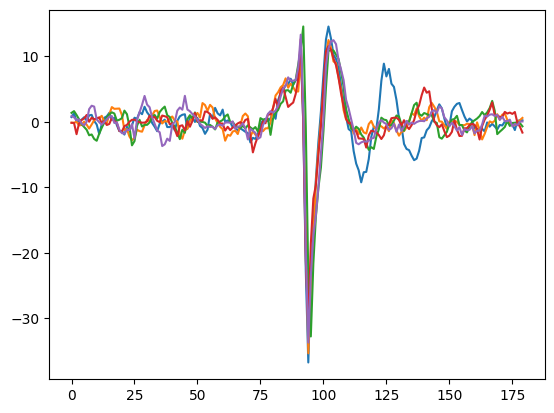

In [9]:
# check plot
plt.plot(spike_instances[np.logical_and(spike_cell_labels==EXAMPLE_CELL_ID, spike_channel_ids==EXAMPLE_CHANNEL_ID), :].T);

Extract non-spike data

- for now take data before each cell's first spike (cons: the extracted recording may contain spikes)

In [10]:
# get cells' spikes
spike_ms = pd.read_pickle(SPIKE_FILE_PATH)

# get each cell's first spike 
u, indices = np.unique(spike_ms, return_index=True)

# set a no-spike timestamp 10 ms before each cell's first spike
non_spikes = spike_ms.iloc[indices].sort_index() 
non_spikes.index = non_spikes.index - 10

## Extract noise snippets

In [ ]:
# load pre-computed noise snippets
# (takes 1 min)
if LOAD_WAVEFORM_EXTRACTOR:
    lfp_recording = preprocess.load(data_conf)
    NoiseExtractor = waveform.load(lfp_recording, NOISE_STUDY_FOLDER, ms_before=MS_BEFORE, ms_after=MS_AFTER)
    print(WaveformExtractor)
else:
    # Preprocess traces and extract waveforms
    # (if run, 19 min min, a 10 min campaign, 534 cells)
    # (if LOAD_PREPROCESSED = True, ..)
    NoiseExtractor = waveform.run_from_files(
        experiment=EXPERIMENT, 
        simulation_date=SIMULATION_DATE,
        lfp_trace_file=RAW_LFP_TRACE_FILE_PATH,
        spike_file=SPIKE_FILE_PATH,
        study_folder=NOISE_STUDY_FOLDER,
        ms_before=MS_BEFORE,
        ms_after=MS_AFTER,
        load_preprocessed=LOAD_PREPROCESSED
        )

In [11]:
# # Preprocess traces and extract waveforms 
# # (93 min, a 10 min campaign, 534 cells)
# NoiseExtractor = waveform.run_from_files(
#     experiment=EXPERIMENT, 
#     simulation_date=SIMULATION_DATE,
#     lfp_trace_file=RAW_LFP_TRACE_FILE_PATH,
#     spike_file=SPIKE_FILE_PATH,
#     study_folder=NOISE_STUDY_FOLDER,
#     ms_before=MS_BEFORE,
#     ms_after=MS_AFTER,
#     load_preprocessed=LOAD_PREPROCESSED
#     )

2023-05-08 18:53:54,845 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-08 18:53:54,913 - root - utils.py - get_config - INFO - Reading experiment config. - done
Set parameters in  24.585252285003662 sec
Loaded raw recording and spikes in  0.45881104469299316 sec
Found spike loc for trace sampfreq in  0.256178617477417 sec
Loaded preprocessed recording in  0.006348133087158203 sec
write_binary_recording with n_jobs = 1 and chunk_size = None
Created study in  20.927649974822998 sec
Computed waveforms in  381.7468683719635 sec
Extracted waveforms in  752.2434484958649 sec


In [12]:
# format noise instances
out = get_instances(NoiseExtractor, cell_ids = CELL_IDS)
non_spike_instances = out["instances"]
non_spike_channel_ids = out["channel_ids"]
non_spike_cell_labels = out["cell_labels"]
non_spike_status = np.repeat(0,len(out["instances"]))

Stack spike and non-spike signals

In [13]:
# stack
instances = np.vstack([spike_instances, non_spike_instances])
channel_ids = np.hstack([spike_channel_ids, non_spike_channel_ids])
cell_labels = np.hstack([spike_cell_labels, non_spike_cell_labels])
spike_status = np.hstack([spike_status, non_spike_status])

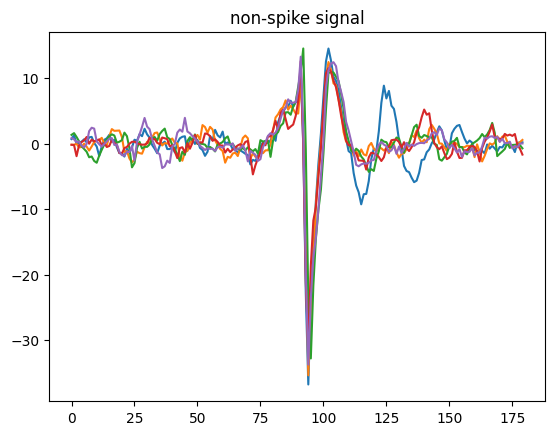

In [14]:
# check plot
plt.plot(non_spike_instances[np.logical_and(non_spike_cell_labels==EXAMPLE_CELL_ID, non_spike_channel_ids==EXAMPLE_CHANNEL_ID), :].T);
plt.title("non-spike signal");

### Label spike instances with their nearest channel contact

In [15]:
# cell coordinates
cell_true_coord = simulation["circuit"].cells.get(CELL_IDS, properties=["x","y","z"])

if LOAD_PREPROCESSED:
    recording = probe_wiring.load(data_conf)
else:
    # preprocess recording
    recording = preprocess.run(data_conf, param_conf)

    # wire probe
    recording = probe_wiring.run(data_conf, param_conf)

# get probe coordinates
probe = recording.get_probe()
channel_coord = probe.contact_positions

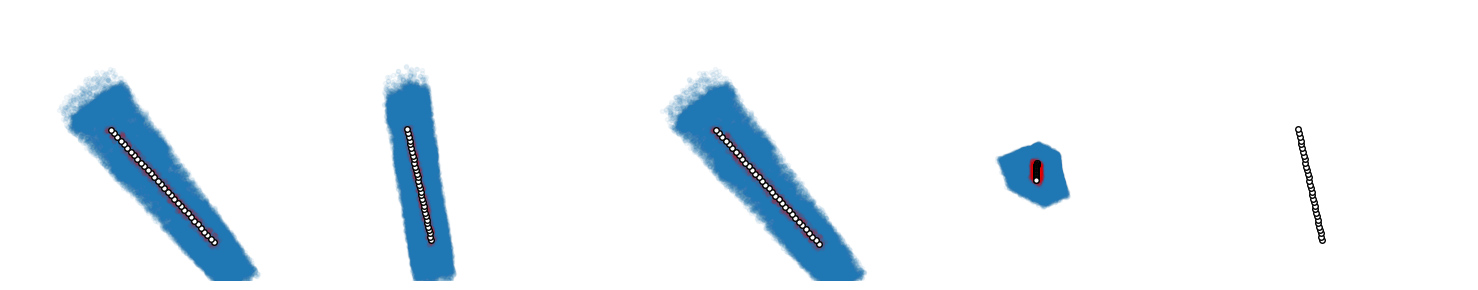

In [16]:
# check probe locations
cell_coords = simulation["circuit"].cells.positions()

# get microcircuit cell coords
microcircuit_cells = filter_microcircuit_cells(simulation)["gid"]
microcircuit_cells_coords = cell_coords.loc[microcircuit_cells]

# get target cell coords
target_cell_coords = cell_coords.loc[CELL_IDS]

# plot
fig = viz.plot_probe_with_circuit(
    cell_coord=microcircuit_cells_coords, 
    target_cell_coord=target_cell_coords, 
    probe_coord=channel_coord, 
    contact_ids = probe.contact_ids
    )

In [17]:
# calculate euclidean distance b/w cells and channel contacts
nearest_channel = []
for c_i, cell_i in enumerate(cell_true_coord.index):
    channel_dist = []
    for ch_i in range(channel_coord.shape[0]):
        channel_dist.append(scipy.spatial.distance.euclidean(cell_true_coord.iloc[c_i], channel_coord[ch_i, :]))
    nearest_channel.append(np.argmin(np.array(channel_dist)))
nearest_channel_series = pd.Series(data=nearest_channel, index=cell_true_coord.index)

Check an example cell and its nearest channel contact

cell 19690 (red) and its nearest contact channel (30, blue) among channels (gray)


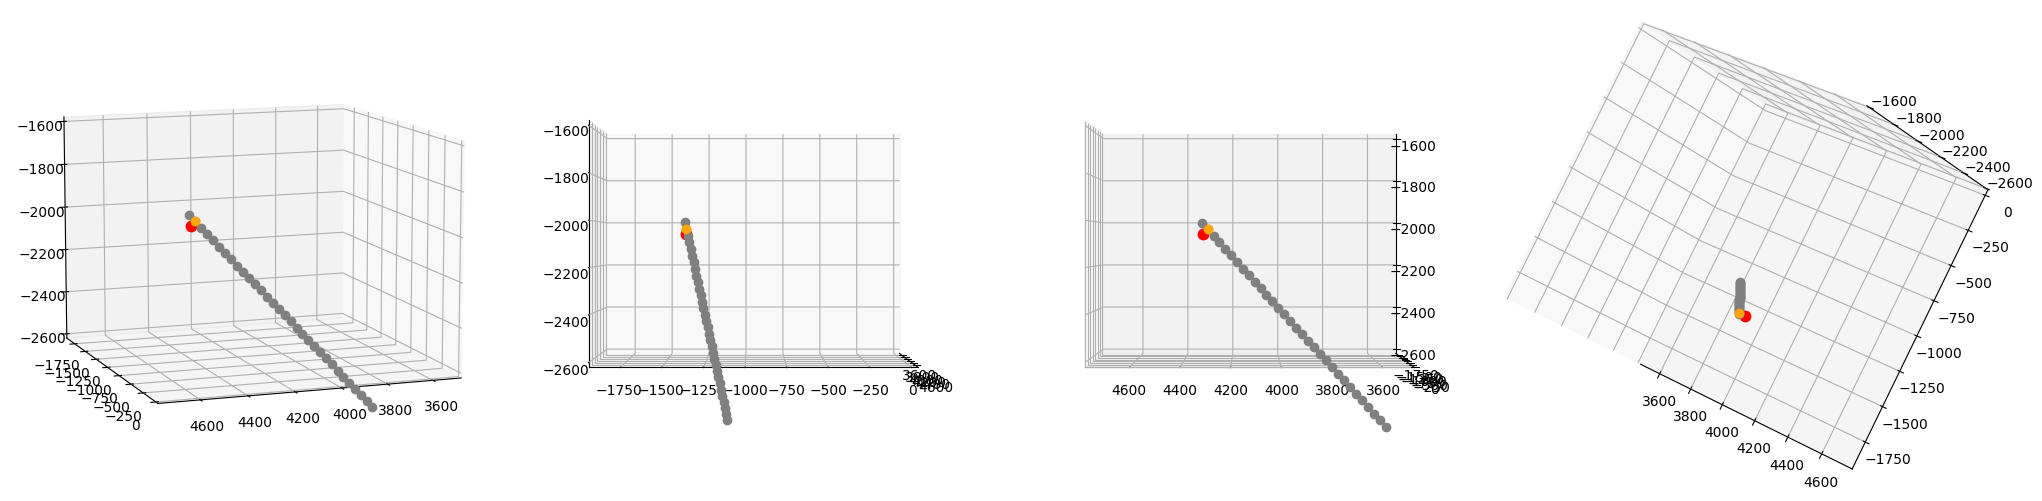

In [18]:
# Show example 
this_neuron = EXAMPLE_CELL_ID
this_neuron_coord = cell_true_coord.loc[this_neuron]
cell_nearest_channel = nearest_channel_series.loc[this_neuron]

# Quick check all coordinates
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(141, projection='3d')
ax.view_init(10, 70)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[cell_nearest_channel,0], channel_coord[cell_nearest_channel,1], channel_coord[cell_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(142, projection='3d')
ax.view_init(0, 0)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[cell_nearest_channel,0], channel_coord[cell_nearest_channel,1], channel_coord[cell_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(143, projection='3d')
ax.view_init(0, 90)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[cell_nearest_channel,0], channel_coord[cell_nearest_channel,1], channel_coord[cell_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(144, projection='3d')
ax.view_init(50, -5, 60)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".",markersize=15, linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[cell_nearest_channel,0], channel_coord[cell_nearest_channel,1], channel_coord[cell_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);
plt.tight_layout()
print(f"cell {EXAMPLE_CELL_ID} (red) and its nearest contact channel ({cell_nearest_channel}, blue) among channels (gray)")

Label dataset with cell's nearest channel

In [19]:
# takes 50 secs for 1000ish cells
nearest_channel = [] 
for cell_i in cell_labels:
    nearest_channel.append(nearest_channel_series.loc[cell_i])

cell 877199 (red) and its nearest contact channel (8, blue) among channels (gray)


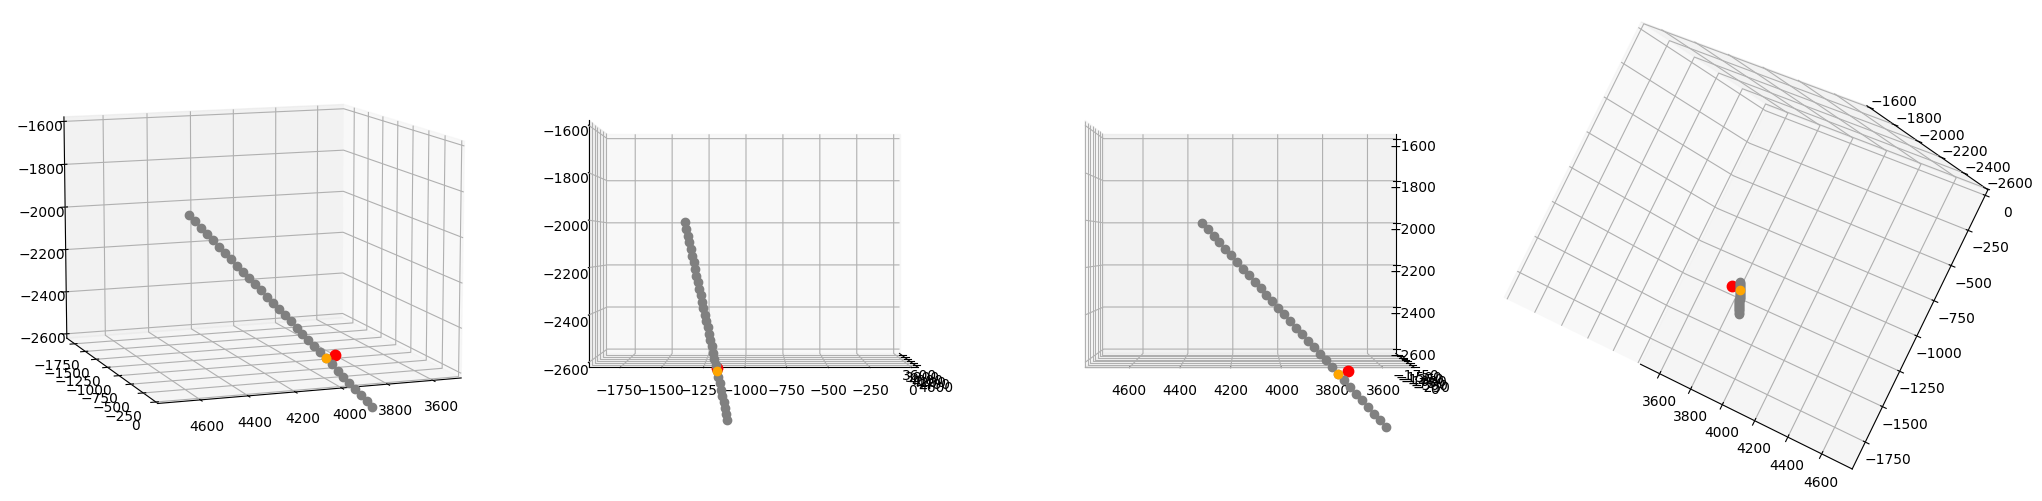

In [20]:
# Check another example 
ix = 50000
this_neuron = cell_labels[ix]
this_neuron_coord = cell_true_coord.loc[this_neuron]
this_nearest_channel = nearest_channel[ix]

# Quick check all coordinates
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(141, projection='3d')
ax.view_init(10, 70)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[this_nearest_channel,0], channel_coord[this_nearest_channel,1], channel_coord[this_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(142, projection='3d')
ax.view_init(0, 0)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[this_nearest_channel,0], channel_coord[this_nearest_channel,1], channel_coord[this_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(143, projection='3d')
ax.view_init(0, 90)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[this_nearest_channel,0], channel_coord[this_nearest_channel,1], channel_coord[this_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(144, projection='3d')
ax.view_init(50, -5, 60)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".",markersize=15, linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[this_nearest_channel,0], channel_coord[this_nearest_channel,1], channel_coord[this_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);
plt.tight_layout()

print(f"cell {this_neuron} (red) and its nearest contact channel ({this_nearest_channel}, blue) among channels (gray)")

# WRITE

In [21]:
parent_path = os.path.dirname(data_conf["postprocessing"]["shape_study"]["instances"])
if not os.path.isdir(parent_path):
    os.makedirs(parent_path)

# takes 12 secs for 1000ish cells, 128 channels
pd.DataFrame(instances).to_pickle(INSTANCE_FILE_PATH)
pd.DataFrame(channel_ids).to_pickle(CHANNEL_IDS_FILE_PATH)
pd.DataFrame(cell_labels).to_pickle(CELL_LABELS_FILE_PATH)
pd.DataFrame(spike_status).to_pickle(SPIKE_STATUS_FILE_PATH)
pd.DataFrame(nearest_channel).to_pickle(NEAREST_CHANNEL_FILE_PATH)